# Dogs vs. Cats Redux: Kernels Edition - implemented from scratch using VGG16 weights

### First get standard boilerplate imports out of the way

In [1]:
%matplotlib inline

In [2]:
from __future__ import division,print_function

#import os, json
from time import time
#from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

### Define path and batch_size for desired data source

In [3]:
batch_size = 64

In [4]:
#path = "data/"
#test_path = "data/test/"

path = "data/sample/"
test_path = "data/sample/test/"


## Create VGG16 model and load pre-trained weights from ImageNet

In [5]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.optimizers import SGD, RMSprop, Adam

Using Theano backend.
WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: unknown error)


### Preprocess routine to center each image pixel around dataset RGB mean value, and reverse axis from RGB -> BGR

In [6]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))

In [7]:
def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1]

In [8]:
model = Sequential()


### Add Input Layer for images with dimension 244 x 244

In [9]:
model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

### Add Convolutional Layers

In [10]:
def ConvBlock(mymodel, layers, filters):
    for i in range(layers):
        mymodel.add(ZeroPadding2D((1,1)))
        mymodel.add(Convolution2D(filters, 3, 3, activation='relu'))
    mymodel.add(MaxPooling2D((2,2), strides=(2,2)))

In [11]:
ConvBlock(model, 2, 64)
ConvBlock(model, 2, 128)
ConvBlock(model, 3, 256)
ConvBlock(model, 3, 512)
ConvBlock(model, 3, 512)

### Add Fully Connected Layers

In [12]:
def FCBlock(mymodel):
    mymodel.add(Dense(4096, activation='relu'))
    mymodel.add(Dropout(0.5))

In [13]:
model.add(Flatten())
FCBlock(model)
FCBlock(model)

### Add final output Dense Layer

In [14]:
model.add(Dense(1000, activation='softmax'))

### Download and load pre-trained model weights from Imagenet

In [16]:
fname = 'vgg16.h5'
baseurl = 'http://files.fast.ai/models/'
local_weights = get_file(fname, baseurl+fname, cache_subdir='models')

553435136/553482496 [============================>.] - ETA: 0s

In [17]:
model.load_weights(local_weights)

## Finetune VGG16 by replacing last layer with a Dense layer

In [18]:
model.pop()

Make all remaining layers read-only, since we want to leverage all the pre-trained weights

In [19]:
for layer in model.layers: layer.trainable=False

Get batch of data for training and validation

In [20]:
def get_batches(path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
    return gen.flow_from_directory(path, target_size=(224,224), class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [21]:
train_batches = get_batches(path+'train', batch_size=batch_size)
valid_batches = get_batches(path+'valid', batch_size=batch_size)

Found 200 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


### Now add new Dense layer with number of classes we are training with, and compile.

In [22]:
model.add(Dense(train_batches.nb_class, activation='softmax'))

In [23]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

### Now fit the model with training and validation batches

In [24]:
model.fit_generator(train_batches, 
                    samples_per_epoch=train_batches.nb_sample,
                    nb_epoch=1,
                    validation_data=valid_batches,
                    nb_val_samples=valid_batches.nb_sample
                   )

Epoch 1/1
200/200 [==============================] - 95s - loss: 1.3108 - acc: 0.5900 - val_loss: 0.3244 - val_acc: 0.8500


### Generate test predictions

In [25]:
test_batches = get_batches(test_path, shuffle=False, batch_size=2*batch_size, class_mode=None)

Found 50 images belonging to 1 classes.


In [26]:
test_predictions = model.predict_generator(test_batches, test_batches.nb_sample)

### Generate Kaggle submission file

In [27]:
test_image_ids = np.array([int(f[8:f.find('.')]) for f in test_batches.filenames])


So to play it safe, we use a sneaky trick to round down our edge predictions.
Swap all ones with .95 and all zeros with .05

In [28]:
test_predictions = test_predictions.clip(min=0.05, max=0.95)
dog_predictions = test_predictions[:,1]
subm = zip(test_image_ids, dog_predictions)

Write Kaggle submission file

In [29]:
submission_file_name = 'submission_' + str(int(time())) + '.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

### Visualize the prediction by plotting a few

Helper function to plot images for chosen indices

In [30]:
from utils import plots
def plots_idx(idx, path, filenames, probabilities):
    my_image_ids = np.array([int(filenames[i][8:filenames[i].find('.')]) for i in idx])
    my_probabilities = [probabilities[i] for i in idx]
    my_labels = ["{}={:0.2f}".format(i, j) for i,j in zip(my_image_ids, my_probabilities)]
    plots([image.load_img(path + filenames[i]) for i in idx], titles=my_labels)

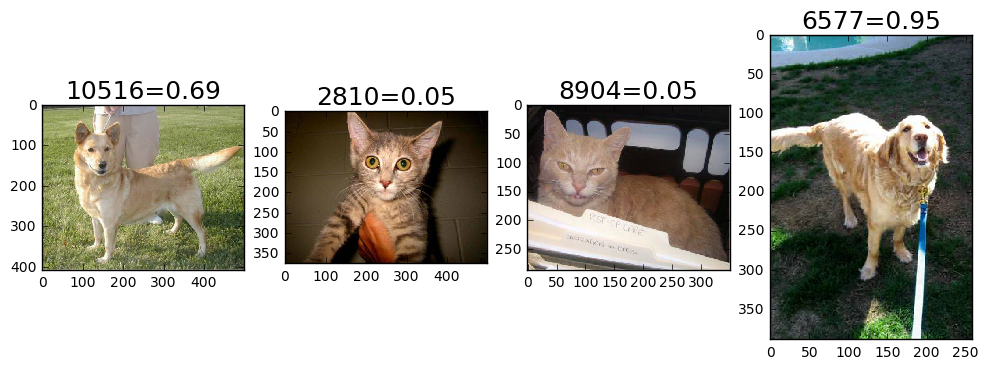

In [33]:
n_view = 4

idx = np.random.permutation(range(0,test_batches.nb_sample))[:n_view]
plots_idx(idx, test_path, test_batches.filenames, dog_predictions)